# MOM-SIS-01 Salinity Restoring Analysis

This notebook contains diagnostics with a series of different simulations aiming to understand the impact of changing vertical resolution in the 0.1° model and its intereaction with surface salinity restoring. This version of the model uses MOM5 with SIS and CORE2-NYF forcing. We compare our original 50 level (GFDL50) version with different implementations of the 75 level (KDS75) configuration.

In [1]:
%matplotlib inline

from cosima_cookbook import build_index, get_nc_variable, expts, memory, DataDir
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from glob import glob
import os

# select only mom01v5 experiments
expts = [expt for expt in expts if 'mom01v5' in expt]
print(expts)

['mom01v5/GFDL50', 'mom01v5/KDS75', 'mom01v5/KDS75_PI', 'mom01v5/KDS75_UP', 'mom01v5/KDS75_salt10days', 'mom01v5/KDS75_saltfluxes', 'mom01v5/KDS75_wind']


## Salinity Restoring Fluxes

Making maps of the fluxes due to salinity restoring for the GFDL50 and KDS75 cases. These maps are an annual average, taken at approximately a similar stage of spinup (but not the identical year).


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


Widget Javascript not detected.  It may not be installed or enabled properly.


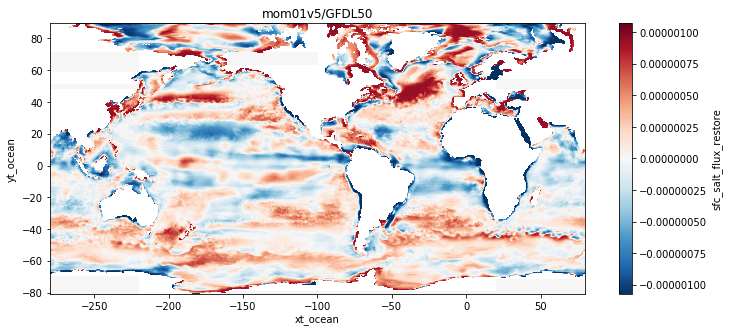

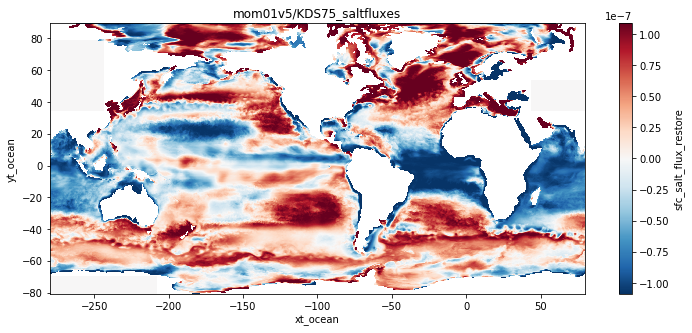

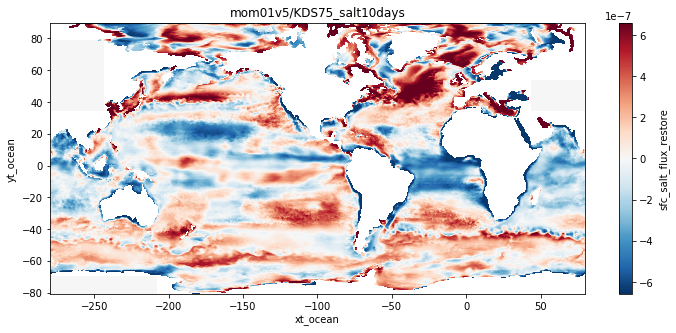

In [2]:
for expt in [expts[i] for i in [0, 5, 4]]:
    salt_flux = get_nc_variable(expt, 'ocean_month.nc', 'sfc_salt_flux_restore', n=4,
                           chunks={'xu_ocean':None})

    mean_salt_flux = salt_flux.mean('time')

    plt.figure(figsize=(12,5))
    mean_salt_flux.plot()
    plt.title(expt)

**In these figures** the difference between the top two panels is a ten-fold decrease in the the upper cell thickness, resulting in about a 5-fold decrease in flux due to restoring (See colorbar). This effect can be offset by reducing the salinity restoring timescale by a factor of 6 (from 60 days to 10 days; lowest panel).

The question remains: How much of the difference between GFDL50 and KDS75 is due to this effective change in salinity restoring?

## Overturning Circulation

In [3]:
%%time
## create zonally averaged overturning file for each experiment.
for expt in expts:
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*'))
    FileList.sort()
    
    for fn in FileList:
        MOCFile = os.path.join(fn, 'overturning.nc')
    
        # Have I Processed this one yet?
        if not os.path.exists(MOCFile):
            print(fn)
            OceanFile = os.path.join(fn, 'ocean.nc')
            if os.path.exists(OceanFile):
                dsx = xr.open_dataset(OceanFile, decode_times=False, engine='netcdf4')
                psi = dsx.ty_trans_rho.isel(time=0).sum('grid_xt_ocean').cumsum('potrho')
                dsx.close()
                psi.to_netcdf(MOCFile, mode='w', engine='netcdf4')
                print('Saved ', MOCFile)

/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output328
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output329
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output330
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output331
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output332
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output333
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output334
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output335
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output336
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output337
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output338
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output339
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output340
/g/data3/hh5/tmp/cosima/mom01v5/GFDL50/output341
/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output063
/g/data3/hh5/tmp/cosima/mom01v5/KDS75/output065
/g/data3/hh5/tmp/cosima/mom01v5/KDS75_salt10days/output297
Saved  /g/data3/hh5/tmp/cosima/mom01v5/KDS75_salt10days/output297/overturning.nc
/g/data3/hh5/tmp/cosima/mom01v5/KDS75_salt10days/output298
Saved  /g/data3/hh5

(718320, 722700)

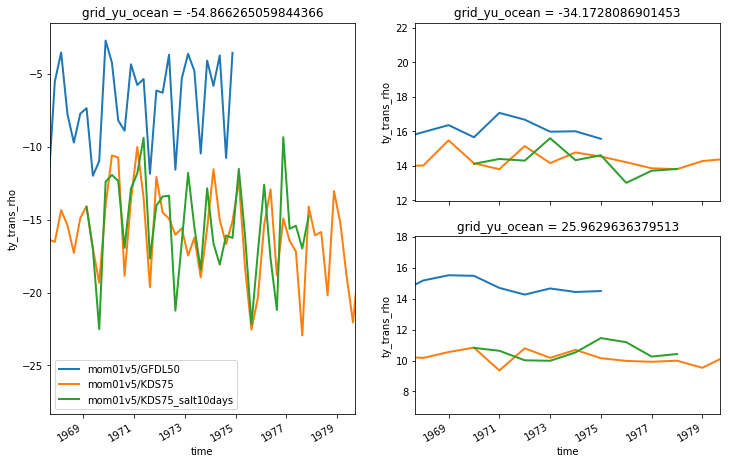

In [4]:
# TODO - modify this cell to use get_nc_variable ...
plt.figure(figsize=(12,8))
for expt in [expts[i] for i in [0, 1, 4]]:
    ExpDir = os.path.join(DataDir, expt)
    FileList = glob(os.path.join(ExpDir, 'output*/overturning.nc'))
    FileList.sort()

    dsx = xr.open_mfdataset(FileList, concat_dim='time',decode_times=False, engine='netcdf4')
    dsx.time.attrs["units"] = 'days since 1900-01-01'
    dsx = xr.decode_cf(dsx, decode_times=True)
    
    plt.subplot(121)
    #dsx.ty_trans_rho[:,60:,585].min('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 
    dsx.ty_trans_rho[:,60:,585].min('potrho').plot(label=expt,linewidth=2) 
 
    plt.subplot(222)
    dsx.ty_trans_rho[:,60:,880].max('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 
    #dsx.ty_trans_rho[:,60:,880].max('potrho').plot(label=expt,linewidth=2) 
    
    plt.subplot(224)
    dsx.ty_trans_rho[:,60:,1513].max('potrho').resample('A',dim='time').plot(label=expt,linewidth=2) 
    #dsx.ty_trans_rho[:,60:,1513].max('potrho').plot(label=expt,linewidth=2) 

plt.subplot(121)
plt.legend(loc='lower left')
plt.xlim([1968*365,1980*365]) 
plt.subplot(222)
plt.xlim([1968*365,1980*365]) 
plt.subplot(224)
plt.xlim([1968*365,1980*365]) 

** These plots show** the lower cell overturning at 55°S (left) and the *annually averaged* upper cell overturning at 35°S and 26°N (right). The ambition is to run the salt10days case for sufficiently long to know whether the difference between GFDL50 and KDS75 is due to the effective salinity restoring or enhanced resolution ... are we there yet?

[I have also checked the lower cell at 65°S (yu_ocean=380) and  the results are even more clear, with no indication of a ramp-down.]

## How big are restoring salt fluxes?

Measure this relative to the total salinity flux.

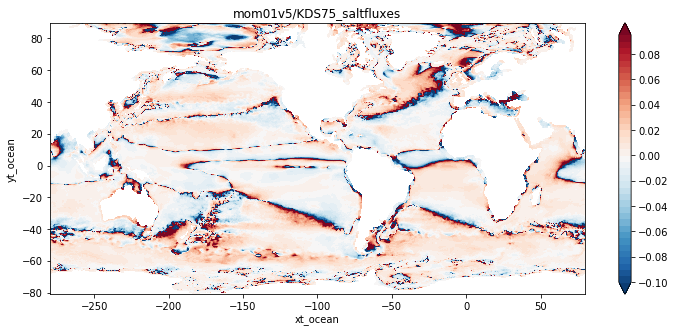

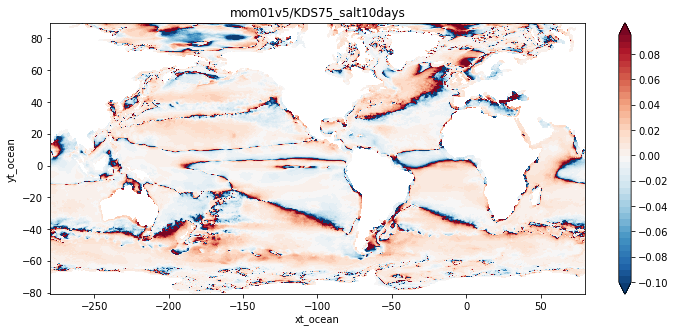

In [5]:
for expt in [expts[i] for i in [5, 4]]:
    pme_river = get_nc_variable(expt, 'ocean_month.nc', 'pme_river', n=4,
                               chunks={'xu_ocean':None})

    mean_pme_river = pme_river.mean('time')
    mean_salt_flux = salt_flux.mean('time')
    salt_flux_ratio = mean_salt_flux/mean_pme_river

    plt.figure(figsize=(12,5))
    salt_flux_ratio.plot(levels=np.arange(-0.1, 0.1, 0.005))
    plt.title(expt)

** The above maps show** restoring salt fluxes as a fraction of the total salt flux (annually averaged). They show that the salinity restoring is a very small component of the total flux at any location, except at cross-over points where P-E is negligible.

### Salinity biases

How different are the salinity biases with different restoring fluxes?

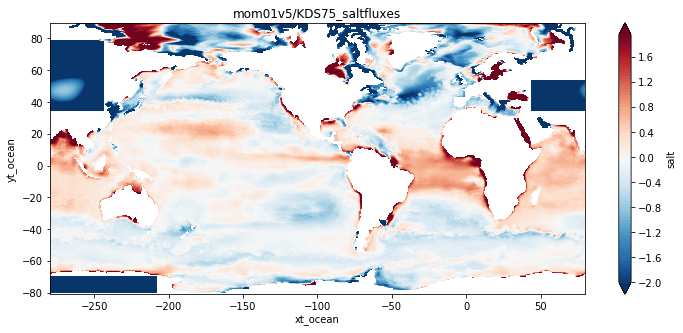

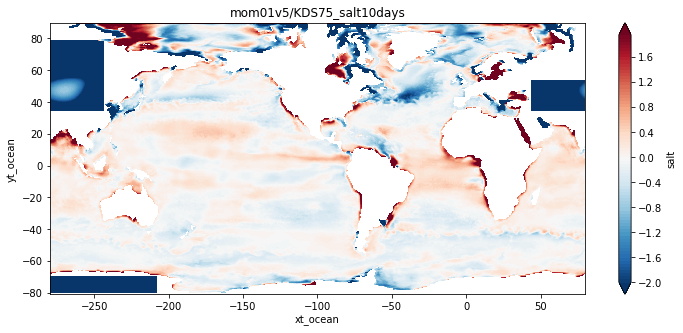

In [6]:
SaltClimatologyFile = os.path.join(DataDir,'mom01v5/climatology/salt_sfc_restore.nc')
dsx = xr.open_dataset(SaltClimatologyFile, decode_times=False, engine='netcdf4')
SalinityRestoring = dsx.SALT.mean("TIME").values
for expt in [expts[i] for i in [5, 4]]:
    salt = get_nc_variable(expt, 'ocean_month.nc', 'salt', n=4,
                               chunks={'xu_ocean':None})

    mean_salt = salt.isel(st_ocean=0).mean('time')
    salt_anomaly = mean_salt - SalinityRestoring

    plt.figure(figsize=(12,5))
    salt_anomaly.plot(levels=np.arange(-2, 2, 0.05))
    plt.title(expt)


## Conclusions

At this stage, it would appear that the difference in salt restoring in the KDS75 and GFDL50 cases is not responsible for the change in overturning. But we should probably run for a little longer before we can be certain of this.